In [1]:
import os
import pathlib

ROOT_PATH = pathlib.Path(__name__).resolve().parent.parent
print(ROOT_PATH)
RANDOM_SEED = 42

/Users/andrey/PycharmProjects/vector-search-hse


In [2]:
os.chdir(ROOT_PATH)
os.getcwd()

'/Users/andrey/PycharmProjects/vector-search-hse'

In [3]:
from vs.storages.local import LocalVideoInfoStorage

FILE_NAME = ROOT_PATH / "data/video_metadata.json"
storage = LocalVideoInfoStorage.from_file(FILE_NAME)

# Qdrant Create Collection

In [5]:
# Import client library
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

client = QdrantClient("http://localhost:6333")

/Users/andrey/PycharmProjects/vector-search-hse/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [81]:
COLLECTION_NAME = "tiktok_vectors"

client.delete_collection(COLLECTION_NAME)


if not client.collection_exists(COLLECTION_NAME):
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(
            size=512,
            on_disk=True,
            distance=Distance.COSINE,
        ),
        on_disk_payload=True,
    )

# Embed Video Frames and Upload to Db

In [82]:
from fastembed import ImageEmbedding, TextEmbedding

img_embedder = ImageEmbedding(model_name="Qdrant/clip-ViT-B-32-vision")
txt_embedder = TextEmbedding(model_name="Qdrant/clip-ViT-B-32-text")

In [83]:
from qdrant_client import models
from tqdm import tqdm

for video in tqdm(storage.videos[:40]):
    image_paths = [img.path for img in video.images]
    embeddings = img_embedder.embed(image_paths)

    points = [
        models.PointStruct(
            # По id векторы не дублируются
            id=image.id,
            vector=vector,
            payload={
                "image_path": image.path,
                "video_path": video.video_path,
                "video_id": video.id,
            },
        )
        for vector, image in zip(embeddings, video.images)
    ]
    client.upsert(
        collection_name=COLLECTION_NAME,
        points=points,
    )

100%|██████████| 40/40 [02:45<00:00,  4.13s/it]


# Qdrant Base Search

In [84]:
import numpy as np


def get_text_embedding(text: str) -> np.ndarray:
    return list(txt_embedder.embed(text))[0]

In [85]:
from qdrant_client.models import ScoredPoint


def query_vectors(query: str, n_limit: int = 10) -> list[ScoredPoint]:
    vector = get_text_embedding(query)

    result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=vector,
        limit=n_limit,
        with_vectors=False,  # True if want to see vector
    )
    return result.points


points = query_vectors("aircraft", n_limit=50)
points[:5]

[ScoredPoint(id='ae9fe331-0dda-4a04-a644-462e79d693a8', version=5, score=0.276908, payload={'image_path': 'data/images/c6aebf2988c74ca4b67f3061eb68785f/000360.png', 'video_path': 'data/video/IMG_1348.MOV', 'video_id': 'c6aebf2988c74ca4b67f3061eb68785f'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='0d09020b-27bb-4758-aa8c-fdbb4a4bae20', version=5, score=0.2758844, payload={'image_path': 'data/images/c6aebf2988c74ca4b67f3061eb68785f/000090.png', 'video_path': 'data/video/IMG_1348.MOV', 'video_id': 'c6aebf2988c74ca4b67f3061eb68785f'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='11f0a951-c418-4ad6-86fc-ebc6915ebad1', version=5, score=0.2608048, payload={'image_path': 'data/images/c6aebf2988c74ca4b67f3061eb68785f/000300.png', 'video_path': 'data/video/IMG_1348.MOV', 'video_id': 'c6aebf2988c74ca4b67f3061eb68785f'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='7555fe9c-7e98-4aaf-a208-7f66f916f079', version=5, score=0.2589762, paylo

In [86]:
from typing import Any


def get_per_video_results(
    points: list[models.ScoredPoint],
) -> dict[str, Any]:
    """Compute per video results."""

    uniq_videos = {point.payload.get("video_id") for point in points}

    data = {
        video_id: {"id": video_id, "n_freq": 0, "avg_sim": 0, "images": []}
        for video_id in uniq_videos
    }

    for point in points:
        payload = point.payload
        video_id = payload.get("video_id")
        data[video_id]["n_freq"] += 1
        data[video_id]["images"].append(
            {"id": point.id, "image": payload.get("image_path"), "score": point.score}
        )

    scored_data = sorted(
        list(data.values()), key=lambda x: x.get("n_freq"), reverse=True
    )

    return [score_obj for score_obj in scored_data if score_obj["n_freq"] > 4]


stat_data = get_per_video_results(points)
stat_data

[{'id': 'db8daaf8a0eb4a948b6082edb90e6443',
  'n_freq': 13,
  'avg_sim': 0,
  'images': [{'id': '845738c2-3fa6-473c-b17e-8b484ce587c0',
    'image': 'data/images/db8daaf8a0eb4a948b6082edb90e6443/007230.png',
    'score': 0.25068632},
   {'id': 'f4ece25e-3306-4145-b870-a339719ce115',
    'image': 'data/images/db8daaf8a0eb4a948b6082edb90e6443/007290.png',
    'score': 0.24158403},
   {'id': '47a79877-e1cd-4212-bab7-b75f439ea9df',
    'image': 'data/images/db8daaf8a0eb4a948b6082edb90e6443/007110.png',
    'score': 0.23878542},
   {'id': 'f84d4ca1-b3bb-45ea-9455-ed39307dc9aa',
    'image': 'data/images/db8daaf8a0eb4a948b6082edb90e6443/007440.png',
    'score': 0.23872185},
   {'id': 'd3f2aac2-1066-4e92-9d50-97955c313bce',
    'image': 'data/images/db8daaf8a0eb4a948b6082edb90e6443/007140.png',
    'score': 0.23841473},
   {'id': 'e79589f2-4b49-4843-9a3a-101586364508',
    'image': 'data/images/db8daaf8a0eb4a948b6082edb90e6443/007500.png',
    'score': 0.23837432},
   {'id': '14fd92c9-38cc-4

In [87]:
from matplotlib import pyplot as plt
from PIL import Image


def plot_images_with_scores(
    video_name: str,
    images: list,
):
    plt.figure(figsize=(7, 7))
    plt.suptitle("Video {}".format(video_name))
    plt.tight_layout()
    for i in range(min(16, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.title(images[i].get("score"))
        plt.axis("off")
        # plt.subtitle(scores[i])
        plt.imshow(Image.open(images[i].get("image")))
    plt.show()
    plt.close()

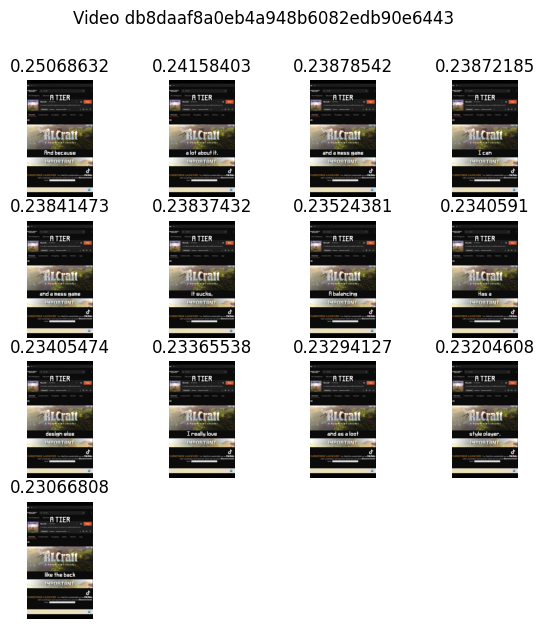

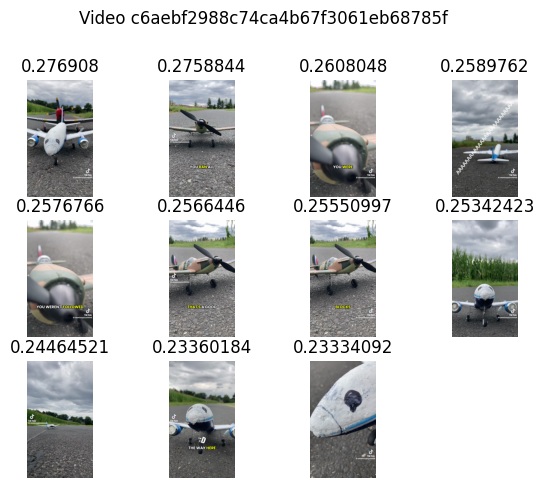

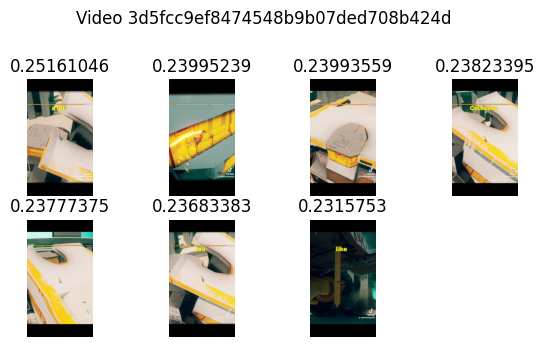

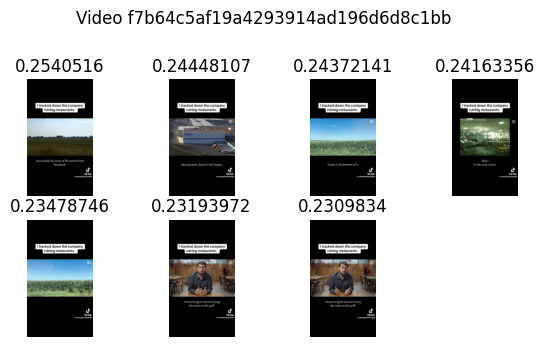

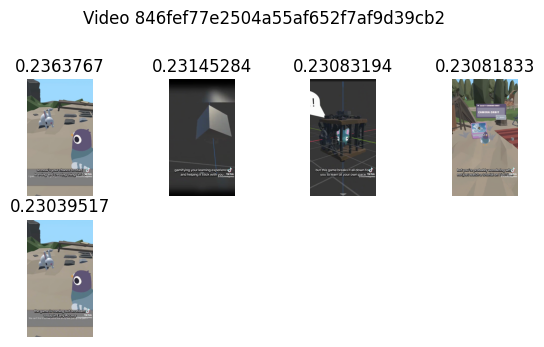

In [88]:
for stat in stat_data:
    video_info = storage.get_video_info_by_id(video_id=stat["id"])
    images = stat.get("images", [])

    plot_images_with_scores(
        video_name=video_info.id,
        images=images,
    )